<u><i>Final Word Count:</i> ~1870</u> *(not including code comments/equations/tables)*.

<h4>Run this cell first. User input required.</h4>

In [46]:
## Installs required packages with user prompt if they are not installed

# prompts user for library installation, takes in a library name
check_library <- function(library){
        # take in user input
        if(!(library %in% installed.packages())){
        user.input = readline(prompt = paste("This notebook requires", library, "to run. Check for", library, "Package? (y/n)"))
        user.input = toupper(user.input) # recast user input
            if(user.input != "Y" & user.input != "YES") {
                    # check user input negation messages
                    if(user.input == "N" || user.input == "NO"){
                         print("Please note, this notebook will not run without the package.")
                         print("Exiting...")  }
                     else{
                         print("User input not recognized, please re-run this cell.")
                         print("Exiting...")  }
           } else{print(paste(library, " is not installed. Installing...")) 
                        install.packages(library) } #and install the library            
        } else{ print(paste(library, " is already installed!"))  }
    }

# Run the Library Check function on the required packages
check_library("MASS")
check_library("pracma")
check_library("latex2exp")

# also, try installing matlib if the code doesn't work
# install.packages("matlib")

[1] "MASS  is already installed!"
[1] "pracma  is already installed!"
[1] "latex2exp  is already installed!"


<h4>Import Libraries</h4>

In [47]:
### IMPORT 201 LIBRARIES ###
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(dplyr)
### Import Additional Libraries ###
library(MASS)
library(pracma)
library(latex2exp)
### Prerequisite Plot Settings  ###
options(repr.plot.width = 15, repr.plot.height = 7)

In [48]:
# Additionally, these should all read true
c("tidyverse", "broom", "repr", "digest", "infer", "gridExtra", "dplyr") %in% installed.packages()

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

<h2><u>An Investigation into Maximum River Flow</u></h2>

<h3><u>Introduction</u></h3>

<p>            It is aptly noted by Merkuryeva and Kornevs that “floods are the most common natural disasters that often cause significant economic losses, and human and social tragedies” (2013). Furthermore, in assessing potential damage of floods, the flow rate of a river can correspond to severe damage, in particular, the structural damage of road infrastructure (Kreibich et. al, 2009).

<p>            In this Deliverable Project, we will investigate the monthly flow rate recorded by Station 05BB001 on the Bow River, Banff, Alberta, Canada. In particular, we will determine whether or not there is statistically significant evidence to suggest that the maximum flow rate in the Spring months (April, May and June) are greater than the maximum max flow rate in the Summer months (July, August and September). Such an analysis can be potentially used to inform local governments of <u>which times of year</u> potential floods can cause the most structural damage, and set the stage for larger-scale studies.
    
<p>            We will also utilize this data to study which statistical model best describes the relation of the fastest-flowing months of the year for the Bow River and the Yearly Average Flow Rate for a small dataset. We'll analyze the RSS of the functions determined by Cubic, Linear, Sinusoidal Linear and Logarithmic Regression. The best statistical model representing this association could potentially be used by local governments to predict the yearly average flow rate of the Bow River based solely on the maximum measurements across these months. This would be helpful in determining the likelihood that further months of the year have intense or slow-moving speeds and aid development of predictive models for other stations with less data by providing more precise prior distributions for non-frequentist regression methods. </p>
<p>            The mathematics for these models is introduced prior to each section, but a rigorous understanding is not strictly necessary. </p>


<h3><u>Methods and Results</u></h3>

<h4> Import and Begin Data Cleaning </h4>

In [49]:
# Import CSV From GitHub, originally sourced from https://wateroffice.ec.gc.ca/
df = read.csv("https://raw.githubusercontent.com/cadenhewlett/stat-201-group-33-project/main/monthly_20221102T0350.csv")

# Rename the columns according to original order (which was lost)
colnames(df) = c(
  "ID","PARAM",	"TYPE",	"Year",	"Jan",	"SYM",
  "Feb",	"SYM",	"Mar",	"SYM",	"Apr",	"SYM",
  "May",	"SYM",	"Jun",	"SYM",	"Jul",	"SYM",	"Aug",	
  "SYM",	"Sep",	"SYM",	"Oct",	"SYM",	"Nov",	"SYM",
  "Dec",	"SYM",	"Mean"
)

# Preview the data frame's relevant columns.
cat("Table 0.1.0")
head(df[colnames(df)!='SYM' & colnames(df)!='PARAM' & colnames(df)!='TYPE'])

Table 0.1.0

,ID,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Mean
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ID,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Mean
2,05BB001,1909,,,,,,176,164,70.1,44.7,23.6,,,
3,05BB001,1910,,,,,87.5,151,134,78.7,35.6,34.1,,,
4,05BB001,1911,9.82,9.25,8.56,10.4,35.1,177,126,72.7,42.6,19.2,11.7,10.8,44.5
5,05BB001,1912,8.23,7.55,6.34,8.34,42,97,101,99.9,52.3,28.8,16.5,12.2,40.1
6,05BB001,1913,9.1,7.93,7.24,11.7,39.5,159,101,85.7,55.6,28.6,17.1,11.3,44.6


<h4> Construct Data Filter </h4>

In [71]:
# Create Boolean list selector for filtration and cleaning across target columns
springfilter = (  df$Apr != "" & df$Mean != "" &        # remove empty cells
                  df$May != "" & df$Jun != "" & 
                  df$Apr != "Apr" &  df$Jun != "Jun" &  # remove original headers
                  df$May != "May" &  df$Mean != "Mean"& 
                  df$TYPE != "8" )                      # standardize types

# Apply this same process to the Summer Months
summerfilter = (  df$Jul != "" & df$Mean != "" & 
                  df$Sep != "" & df$Aug != "" & 
                  df$Sep != "Sep" &  df$Aug != "Aug" & 
                  df$Jul != "Jul" &  df$Mean != "Mean"& 
                  df$TYPE != "8" )

# The complete filter is then the union of these two boolean sets
completeFilter = springfilter & summerfilter

# In this table, FALSE indicates the number of elements that we will filter out.
print(table(completeFilter))

completeFilter
FALSE  TRUE 
   13   111 


<h4> Apply Filter to Data Frame </h4>

In [73]:
# Here we subset the different columns of the original dataframe
# According to the filter we constructed in the previous cell.

# Spring Data : April, May and June
apr_filtered =  as.numeric(df$Apr[completeFilter])
may_filtered =  as.numeric(df$May[completeFilter])
jun_filtered =  as.numeric(df$Jun[completeFilter])

# Summer Data : July, August and September
jul_filtered =  as.numeric(df$Jul[completeFilter])
aug_filtered =  as.numeric(df$Aug[completeFilter])
sep_filtered =  as.numeric(df$Sep[completeFilter])

# Create new sub-dataframes with relevant columns
summerDF = data.frame(jul_filtered, aug_filtered, sep_filtered)
springDF = data.frame(apr_filtered, may_filtered, jun_filtered)

# head(cbind(springDF, summerDF)) # a preview of these data is not very relevant


,apr_filtered,may_filtered,jun_filtered,jul_filtered,aug_filtered,sep_filtered
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10.40,35.1,177.0,126,72.7,42.6
2,8.34,42.0,97.0,101,99.9,52.3
3,11.70,39.5,159.0,101,85.7,55.6
4,11.30,52.3,139.0,138,73.7,42.1
5,15.90,45.0,91.6,124,101.0,44.4
6,9.95,27.5,139.0,153,76.2,50.5


<h4>Define Row Max Function</h4>

In [52]:
# Here we define our locally referenced rowMax functon.

# @param i : the row of interest 
# @param threeDF: a dataframe with three numeric columns
# @return  :  the maximum across the dataframe's columns for the row

rowMax = function(i, threeDF){ 
  v = c( threeDF[i, 1], # get each month
         threeDF[i, 2],
         threeDF[i, 3])
  max(as.numeric(v))} # return the max of the three

# @example: 
example = (data.frame(col1 = c(1, 2), col2 = c(3, 5), col3 = c(-1, 5))) #example DF
# prints the example dataframe with the function applied to both rows
cat("Table 0.1.2")
head(example %>% mutate(row_max = c(rowMax(1, example), rowMax(2, example))))


Table 0.1.2

,col1,col2,col3,row_max
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3,-1,3
2,2,5,5,5


<h4>Apply Function to Data Frames </h4>

In [74]:
# Define a new column: result of the rowMax function applied to the Spring DF
springDF[, "max"] <- sapply(1:nrow(springDF), rowMax, threeDF = springDF)

# Define a new column: result of the rowMax function applied to Summer DF
summerDF[, "max"] <- sapply(1:nrow(summerDF), rowMax, threeDF = summerDF)

# Creates the dataset with each of these Maximums, as well as their difference.
maximumDF = tibble(spring = springDF$max, summer = summerDF$max, diff = spring - summer)

# This is now the dataset we'll use for our Hypothesis test and CI 
cat("Table 0.1.3")
# which contains the max across spring, max across summer, and the delta
head(maximumDF)

Table 0.1.3

spring,summer,diff
<dbl>,<dbl>,<dbl>
177.0,126,51.0
97.0,101,-4.0
159.0,101,58.0
139.0,138,1.0
91.6,124,-32.4
139.0,153,-14.0


<h3><u>Part 1: Spring vs. Summer Analysis, Bootstrapping and Asymptotics</u></h3>

<h4> Part 1a: Hypothesis Test for Difference of Means</h4>

<p>  We wish to investigate whether there is statistically significant evidence to suggest that the maximum flow rate in the Spring months (April, May and June) are greater than the max flow rate in the Summer months (July, August and September) for Station 05BB001 on the Bow River. To do this, we'll conduct a Hypothesis Test for Difference of Means. Let $\mu_{\text{sp}}$ and $\mu_{\text{sm}}$ be the mean maximum flow rate ($m^3 / s$) of the Bow River across the Spring and Summer Months respectively. 
<p> 
    We will test the following hypothesis at $\alpha = 0.05$: <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H_0: \mu_{\text{sp}} = \mu_{\text{sm}}$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H_A: \mu_{\text{sp}} > \mu_{\text{sm}}$ <br>
    We will use the fact that: <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\frac{\bar{D}}{S_D  / \sqrt{n}} \sim t_{n-1}$,   using the test statistic   $\;t = \bar{d} \div {\frac{s_d}{\sqrt{n}}}$

In [78]:
# By method of asymptotics, we can compute the test statistic as follows:

# sample mean of differences
d_bar = mean(maximumDF$diff) 

# sample size
n = nrow(maximumDF)

# sample standard error
se = (sd(maximumDF$diff) / sqrt(n))

# define the test statistic as defined above
test_stat = d_bar / se 

# then find the p-value as p(t > test_stat)
p_value = pt(test_stat, df = n - 1, lower.tail = FALSE)

# store our results in a tibble
results = tibble(estimate = d_bar, se, test_stat, p_value)

cat("Table 1.1.a")
results # display our findings

Table 1.1.a

estimate,se,test_stat,p_value
<dbl>,<dbl>,<dbl>,<dbl>
21.23514,3.049097,6.964401,1.266249e-10


[1] 1.266249

<h4> Interpretation </h4>
Our observed p-value ( $p=1.27^{-10}$ ) from these results is less than $\alpha = 0.05$ , we reject the Null Hypothesis at $\alpha$. <br>There is statistically significant evidence to suggest that mean maximum flow rate of the Bow River across the Spring Months of Station 05BB001 on the Bow River is greater than the mean maximum flow rate of the Bow River across the Summer Months. 

<h4> Bootstrap CI for the Mean of the Difference Column </h4>
<p>  We wish to investigate the difference in the maximum flow rate of the Spring months and the Summer months (July, August and September), for Station 05BB001 on the Bow River. Let's construct a Bootstrap Sampling Distribution from our existing data, and build a 95% CI. 

Table 1.1.b

boot_samp_dist_mean,boot_samp_dist_sd,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
21.21431,2.852159,15.50336,26.32457


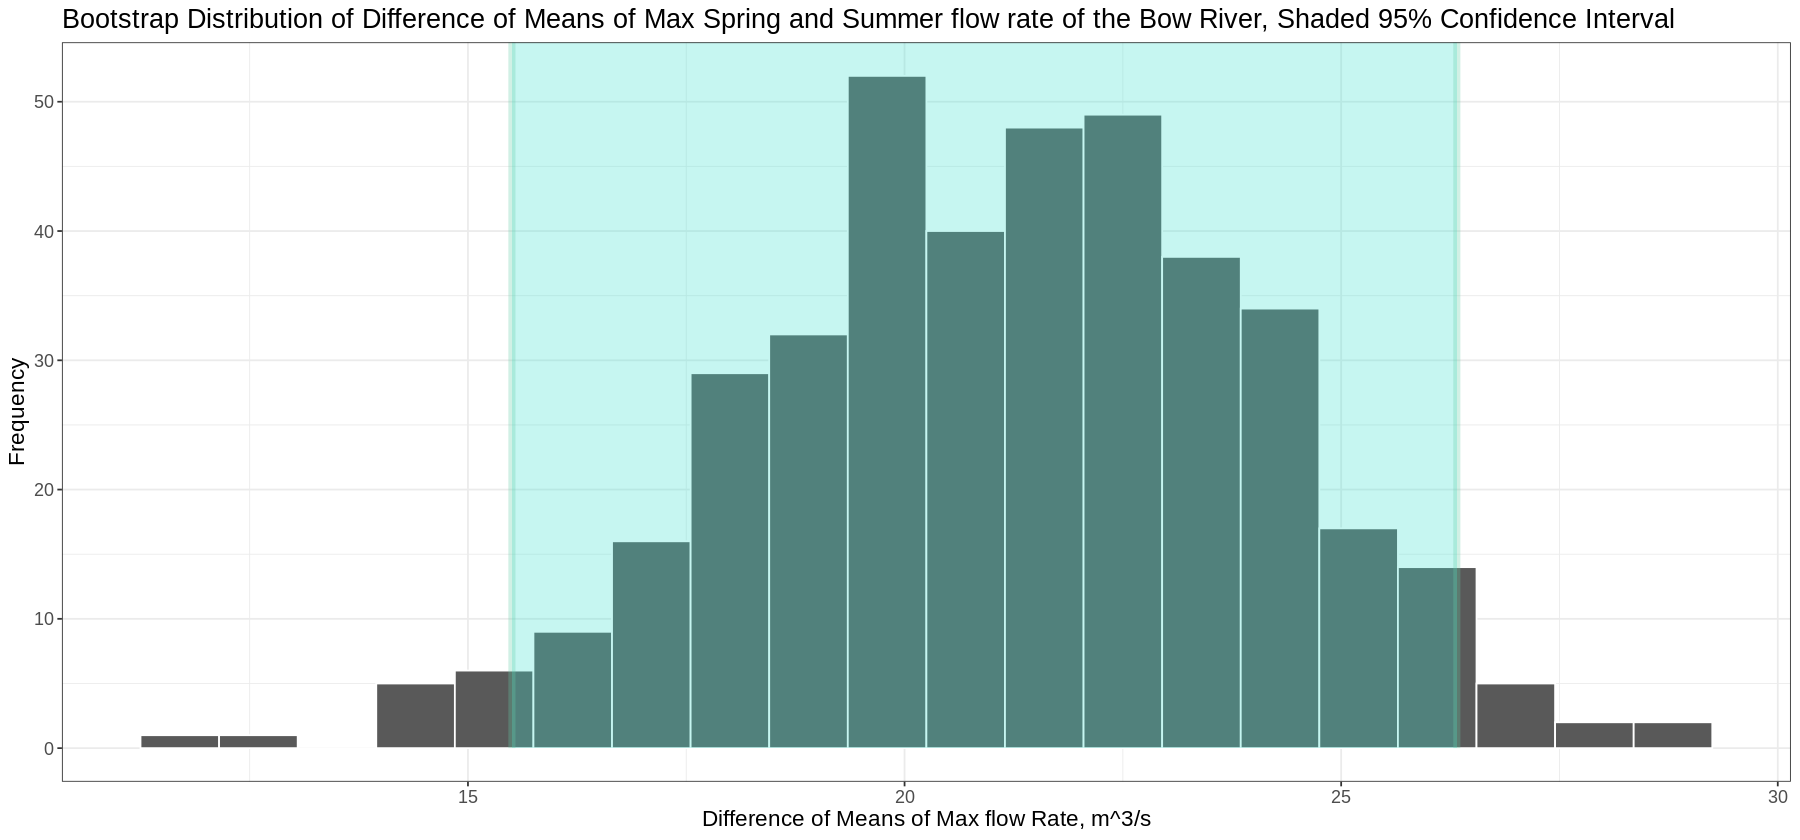

In [85]:
# set seed to 1969-07-16 (launch date of Apollo 11)
set.seed(19690716) 
   
# bootstrap sample 400 times, with replacement
bootstrap_diff_means = tibble(dval = maximumDF$diff) %>% 
                          rep_sample_n(size = n, reps = 400, replace = TRUE) %>% 
                          group_by(replicate) %>% summarise(bootstrap_mean = mean(dval))

# get the confidence interval from these readings
bootstrap_diff_means_ci = bootstrap_diff_means %>% get_ci(type = "percentile", level = 0.95)

# summarize the results
bootstrap_results = tibble(boot_samp_dist_mean = mean(bootstrap_diff_means$bootstrap_mean),
                           boot_samp_dist_sd   = sd(bootstrap_diff_means$bootstrap_mean),
                           bootstrap_diff_means_ci)

# plot the confidence interval
bootstrap_diff_means %>% ggplot(aes(x = bootstrap_mean)) + geom_histogram(binwidth = 0.9, col = 'white') + 
                           theme_bw() + shade_confidence_interval(bootstrap_diff_means_ci, alpha = 0.3) +
                           ggtitle("Bootstrap Distribution of Difference of Means of Max Spring and Summer flow rate of the Bow River, Shaded 95% Confidence Interval") + 
                           labs(x = "Difference of Means of Max flow Rate, m^3/s", y = "Frequency")  + theme(text = element_text(size = 13.5))
cat('Table 1.1.b')
bootstrap_results

<h4>Interpretation </h4>
The 95% bootstrap confidence interval was found to be $CI(0.95) = (15.50, 26.32)$ <br>
The spread and shape of this bootstrap distribution most closely resembles the sampling distribution. We can say with 95% confidence that the true mean of the sampling distribution of difference of Max Spring and Summer flow rate of Station 05BB001 is captured by the interval bounds. If we repeated the same process used to calculate this CI a large number of times, in 95 of 100 of the intervals, the true mean of the sampling distribution will fall in the interval.

In [56]:
# quickly calculate the asymptotic CI for comparison with the bootstrap results
(broom::tidy(t.test(maximumDF$diff, alternative = ("two.sided"))))[, 5:6]

conf.low,conf.high
<dbl>,<dbl>
15.19254,27.27773


<h4>Discussion: Comparison of Asymptotics and Bootstrapping (Part 1)</h4>
In this particular instance, both Bootstrapping and Asymptotics are appropriate. We know Asymptotics can be applied since the data take the shape of an identifiable distribution. Bootstrapping, in turn, will provide a good estimate of the Sampling Distribution; both are equally applicable.<br><br>


One reason the methods gave similar results could be the large difference between max Spring and Summer flow rate. Potential discrepancies between Bootstrapping and Asymptotics are likely mitigated due to effect size. Also, the fact that the sample size was large likely contributed to the observed similarity.  We observed (at $\alpha = 0.05$) the Bootstrap CI was $CI(\alpha) = (15.50, 26.32)$ and the Asymptotic Method CI was $CI(\alpha) = (15.19, 27.28).$ <br><br>
The methods are equally trustworth when properly employed. It is always necessary to be very cautious when using the Asymptotic method, as there are many risks (such as p-hacking) that come with Hypothesis Tests. 

<h4>Discussion: Findings and Future Study (Part 1)</h4>
We found in this section that the Maximum Flow Rate of the Bow River is greater in the Spring Months than the summer months for this particular station. These could perhaps educate the public in that area as well as local governments the time of year in which floods could cause the most damage. In the future, this study could be extended to other rivers, perhaps even with less exhaustive data than the Bow River. We explore in Parts 2 and 3 what such a project could look like.

<h3> <u> Parts 2 and 3: Examination into Approximating Functions </u> </h3>
<p>
    As we saw in Part 1, the dataset for the Bow River Yearly flow rates has over 100 years of historical data. As such, it is fairly straightforward to conduct frequentist methods using the data. However, most river stations have likely been recording data for less time. This begs the question of what to do when there's less data at our disposal. Frequentist approaches may not be best when monitoring yearly readings; one approach is to consider Bayesian methods. <br>
    In general, Bayesian methodology requires a Prior distribution. Without previous knowledge about the data, such prior distributions can be overly broad. Our goal in finding the smallest RSS across the four models of interest is to determine an informed prior for potential future studies.  <br>
    With that in mind, the objective is to use sampling distribution methodology to determine which function has the smallest Residual Sum of Squares (RSS) when comparing flow rates of June, July and August to the yearly mean. <br>


<h3><u>Part 2: Gathering Point Estimates</u></h3>

In [86]:
# We'll begin by constructing a data filter for June, July, August and the Yearly Mean flow rate.

# Create another cross-column filter, like we did before.
datafilter = (   df$Jul != "" & df$Mean != "" & 
                 df$Jun != "" & df$Aug != "" & 
                 df$Jun != "Jun" &  df$Aug != "Aug" & 
                 df$Jul != "Jul" &  df$Mean != "Mean"& 
                 df$TYPE != "8" )

# Filter the original dataframe according to this list
jun_filtered  =  df$Jun[datafilter]
jul_filtered  =  df$Jul[datafilter]
aug_filtered  =  df$Aug[datafilter]
mean_filtered =  df$Mean[datafilter] # with the addition of the mean column

# Create new dataframe with relevant columns
computeDF = data.frame(jun_filtered, jul_filtered, aug_filtered, mean_filtered)

# Define a new column: result of the max function applied to compute df
computeDF[, "max"] <- sapply(1:nrow(computeDF), rowMax, threeDF = computeDF)

# Cast relevant columns to numeric
computeDF$max = as.numeric(computeDF$max)
computeDF$mean_filtered = as.numeric(computeDF$mean_filtered)

<h4>Random Sample from the Data</h4>

In [58]:
# we set the seed to 2002 for this example
set.seed(2002)

# take a random sample of size 20 from the population
trainDF = computeDF %>% rep_sample_n(size = 20) %>% ungroup() %>% dplyr::select(-replicate)

# multiply x by a factor of 0.1 to reduce matrix magnitude (next section)
train_x = 0.1*trainDF$max
train_y = 0.5*trainDF$mean_filtered

# preview the training data
cat("Table 2.1.0")
head(trainDF)

Table 2.1.0

jun_filtered,jul_filtered,aug_filtered,mean_filtered,max
<chr>,<chr>,<chr>,<dbl>,<dbl>
87.6,82.4,53.3,30.3,87.6
110,130,95.9,42.6,130.0
161,116,48.6,41.3,161.0
83.6,79.1,48.6,30.5,83.6
107,70.7,40.6,34.4,107.0
121,95.3,60.3,40.0,121.0


<h4>Visualize the Sample</h4>

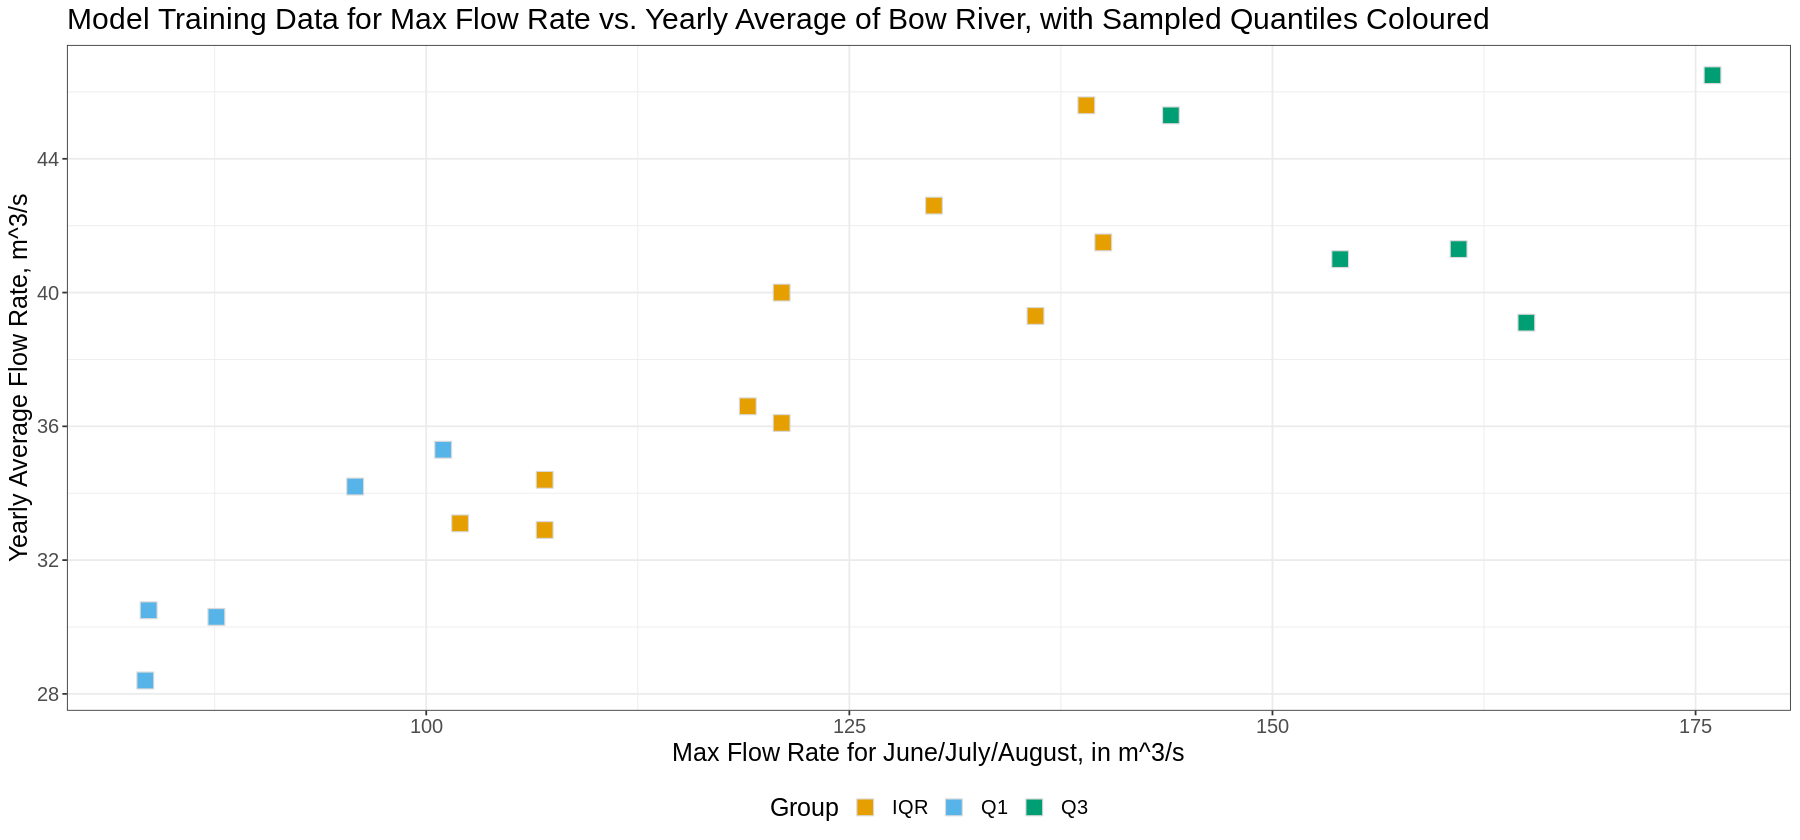

In [59]:
# Locally re-define training data for conciseness of code
x = train_x # this step is no longer stricly needed, 
y = train_y # but we've kept it to be more similar to prior releases

# Visualize the Sample 
trainDF %>% mutate(Group = as.factor( #define a new Factor, which is the sample quantiles
                            ifelse(max <= quantile(max, 0.25), "Q1", # determine quartiles
                                   ifelse(max >= quantile(max, 0.75), "Q3", "IQR")))) %>% 
  ggplot(aes(x = max, y = mean_filtered, fill = Group)) + # then, plot max vs. mean with colour-coded quantiles
  geom_point(shape = 22, color = "grey85", size = 5) +  # makethe points easier to see
  scale_fill_manual(values = c("#E69F00", "#56B4E9", "#009E73"))  + # assign colours to the quantiles
  #  add titles, labels and legend
  ggtitle("Model Training Data for Max Flow Rate vs. Yearly Average of Bow River, with Sampled Quantiles Coloured") + 
  labs(x = "Max Flow Rate for June/July/August, in m^3/s", y = "Yearly Average Flow Rate, m^3/s") + 
  theme_bw() + theme(text = element_text(size = 15), legend.position = "bottom")


<h4>Model 1: Logarithmic Regression (LSE) </h4> <br>
Consider the natural logarithm equation, with constants $\{c_0, c_1\}\in \mathbb{R}$ and $\{x_0, \dots,  x_n\} > 0,$
$$f(x) = c_0 + c_1\ln(x) $$  The coefficients of this single function that minimize the RSS are found by solving $A\vec{c} = \vec{y}$, where:
$$\begin{split}
A = 
\begin{bmatrix}
1 & \ln(x_0)\\
1 &\ln(x_1) \\
\vdots & \vdots \\
 1 & \ln(x_n)
\end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{c}} = \begin{bmatrix} c_0 \\ c_1 \end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{y}} = \begin{bmatrix} y_0 \\ y_1 \\ \vdots \\ y_n \end{bmatrix}
\end{split}$$
<br>
We consider the thin QR Decomposition $A = Q_1R_1$ and solve $R_1\vec{c} = Q_1^{T}\vec{y}$ to find the coefficients, using the pseudoinverse if $A$ is singular.

In [60]:
# define the data matrix
A_log = matrix(c(train_x^0, log(train_x)), ncol = 2)

# Solve the matrix equation c = (A^-1)y to find coefficients c_0, c_1
c_log = tryCatch(
        # try to solve with QR Decomposition
        { qr.solve(A_log, y) },
        #i f the matrix is singular, compute pseudoinverse
        error = function(e) {
            message('Warn: Matrix is Singular, using Pseudoinverse Solution to LSE')
            # compute the pseudoinverse c = A^+ y
            pinv(A_log) %*% y
        })

# define return function, takes an x and returns f(x) from our model 
logtoCurve <- function(x_val){
    # this is equivalent to alog(x) + b
    (c_log[2]*(log(x_val)) + c_log[1])
}

# create plot this particular trial (which we'll visualize later)
plt_log = tibble(train_x, train_y) %>% ggplot(aes(train_x, train_y)) + 
                           geom_point() +  # plot the sample points
                           geom_function(fun = logtoCurve, color = "#D55E00", lwd = 0.7) +  # plots the function
                           ggtitle("Logarithmic Regression for Table 2.1.0 Sample Data")  +  # add titles and labels
                           labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") +
                           theme(axis.text =  element_text(size = 12),
                                 plot.title = element_text(size = 16), 
                                 axis.title = element_text(size = 12))
# plt_log # you can examine the plots independently, too

<h4> Model 2:  Cubic Regression Function  </h4>
This model is found by minimizing the partial derviatives of the RSS function, $$RSS = \sum_{i = 1}^n (y_i - (ax_i^3 + bx_i^2 + cx_i + d))^2$$ With respect to the unknowns: $a$, $b$, $c$ and $d$. <br><br>
We then derive the Matrix Equation $A\vec{c} = \vec{x}$, where: <br>
$$ 
\begin{split}
 A = 
\begin{bmatrix}
\sum x_i^6 & \sum x_i^5 & \sum x_i^4 & \sum x_i^3 \\
\sum x_i^5 & \sum x_i^4 & \sum x_i^3 & \sum x_i^2 \\ 
\sum x_i^4 & \sum x_i^3 & \sum x_i^2 & \sum x_i \\ 
\sum x_i^3 & \sum x_i^2 & \sum x_i &  n  
\end{bmatrix} 
\hspace{10mm}
\boldsymbol{\vec{c}} = \begin{bmatrix} a \\ b \\ c \\ d \end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{x}} = \begin{bmatrix} \sum x_i^3y_i \\ \sum x_i^2y_i \\ \sum x_iy_i \\ \sum y_i \end{bmatrix}
\end{split}
 $$<br>
 We consider the thin QR Decomposition $A = Q_1R_1$ and solve  $R_1\vec{c} = Q_1^{T}\vec{x}$, giving us the coefficients. <br>
 If $A$ is near-singular, we solve $\vec{c} = A^{+}\vec{x}$ using the pseudoinverse $A^{+}$ of $A$.

In [61]:
# Build Matrix from system of Minimization Equations
A_cube = matrix( c( sum(x^6), sum(x^5), sum(x^4), sum(x^3), 
               sum(x^5), sum(x^4), sum(x^3), sum(x^2),
               sum(x^4), sum(x^3), sum(x^2), sum(x^1),
               sum(x^3), sum(x^2), sum(x^1), sum(x^0)), 
            nrow = 4, ncol = 4)

# Build "Results" Vector, y, which is 4x1.
y_cube = matrix( c( sum(x^3 * y), 
                    sum(x^2 * y), 
                    sum(x * y), 
                    sum(y)), # equivalent to x^0*y
            nrow = 4, ncol = 1)


# Solve the matrix equation c = (A^-1)y to find coefficients a and b
c_cube = tryCatch(
        # try to solve with QR Decomposition, R1 x = Q1^T y
        { qr.solve(A_cube, y_cube) },
        #i f the matrix is singular, compute pseudoinverse
        error = function(e) {
            # print('Warn: Matrix is Singular, using Pseudoinverse Solution to LSE')
            # compute the pseudoinverse c = A^+ y
            pinv(A_cube) %*% y_cube
        })

# This function determines the values of the regression line at input x
cubetoCurve <- function(x_val){
    # this is equivalent to ax^3 + bx^2 + cx + d
    (c_cube[1]*(x_val^3) + c_cube[2]*(x_val^2) + c_cube[3]*(x_val) + c_cube[4])
}

# Creates plot with sample data and the corresponding function curve which we'll plot later
plt_reg = tibble(x, y) %>% ggplot(aes(x, y)) + 
                         geom_point() + # plot the sample points
                         geom_function(fun = cubetoCurve, color = "#0090e0", lwd = 0.7) + # plot the cubic regression
                         ggtitle("Cubic Regression for Table 2.1.0 Sample Data") + 
                         labs(y = "Scaled Yearly Average, (m^3/s) ", x = "Scaled Maximums, (m^3/s)") +
                         theme(axis.text =  element_text(size = 12),
                                plot.title = element_text(size = 16), 
                                axis.title = element_text(size = 12))

# plt_reg 

<h4>Model 3: Sinusoidal Linear Regression (by Least Squares Estimation) </h4> 
Consider the sinusoidal linear equation, with $\{c_0, c_1, c_2\}\in \mathbb{R}$
$$f(x) = c_0 + c_1\sin(x) + c_2 x $$  The coefficients are found by solving $A\vec{c} = \vec{y}$, where:
$$\begin{split}
A = 
\begin{bmatrix}
1 & x_0 & \sin(x_0)\\
1 & x_1 & \sin(x_1) \\
\vdots & \vdots & \vdots \\
 1 & x_n & \sin(x_n)
\end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{c}} = \begin{bmatrix} c_0 \\ c_1 \\ c_2 \end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{y}} = \begin{bmatrix} y_0 \\ y_1 \\ \vdots \\ y_n \end{bmatrix}
\end{split}$$
<br>
Using the QR Decomposition $A = Q_1R_1$ to solve $R_1\vec{c} = Q_1^{T}\vec{y}$ for $\vec{c}$.

In [62]:
# define linear sinusoidal matrix as stated above
A_sin = matrix(c (train_x^0, train_x, sin(train_x)), ncol = 3) 

# solve the system R1 c = Q1^T y 
c_sin = qr.solve(A_sin, y)

sintoCurve <- function(x_val){
    # this is equivalent to alog(x) + b
    (c_sin[3]*sin(x_val) + c_sin[2]*(x_val) + c_sin[1])
}

# create plot with superimposed regression line ( which we'll visualize later )
plt_sin = tibble(train_x, train_y) %>% ggplot(aes(train_x, train_y)) + 
                           geom_point() +  # plot the sample points
                           geom_function(fun = sintoCurve, color = "#c25993", lwd = 0.7) +  # plots the polynomial interpolation
                           ggtitle(paste("Sinusoidal Linear Regression for Table 2.1.0 Sample Data"))  + 
                           labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") +
                           theme(axis.text =  element_text(size = 12),
                                plot.title = element_text(size = 16), 
                                axis.title = element_text(size = 12))
#plt_sin 

<h4> Model 4: Linear Regression </h4>
<p> We'll find $\hat{\beta}$ and $\hat{\alpha}$ for the regression model $y = \hat{\alpha} + \hat{\beta} x $ directly, using the following two equations: <br>
     $$ \begin{split}
       \hat{\beta} = \frac{\sum_{i=1}^n(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n(x_i - \bar{x})^2} 
       \hspace{10mm}
       \hat{\alpha} = \bar{y} - \hat{\beta}{\bar{x}}
       \end{split}$$

In [87]:
# determine slope estimate from sample data
beta_hat = sum((x - mean(x))*(y - mean(y))) / sum((x - mean(x))^2)

# determine intercept estimate from sample data
alpha_hat = mean(y) - beta_hat*mean(x)

# Determines the values of the regression line at input x
lineartoCurve <- function(x_val){
    beta_hat*(x_val) + alpha_hat}

# create regression line plot (visualized in the next cell)
plt_lin = tibble(x, y) %>% ggplot(aes(x, y)) + 
                          geom_point() +  # plot sample points
                          geom_function(fun = lineartoCurve, color = "#19bf9b", lwd = 0.7) + # plot reg. line
                          ggtitle("Linear Regression for Table 2.1.0 Sample Data") + 
                          labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") + 
                          theme(axis.text =  element_text(size = 12),
                                plot.title = element_text(size = 16), 
                                axis.title = element_text(size = 12))
#plt_lin

<h4> Plot Each Function with Training Data </h4>

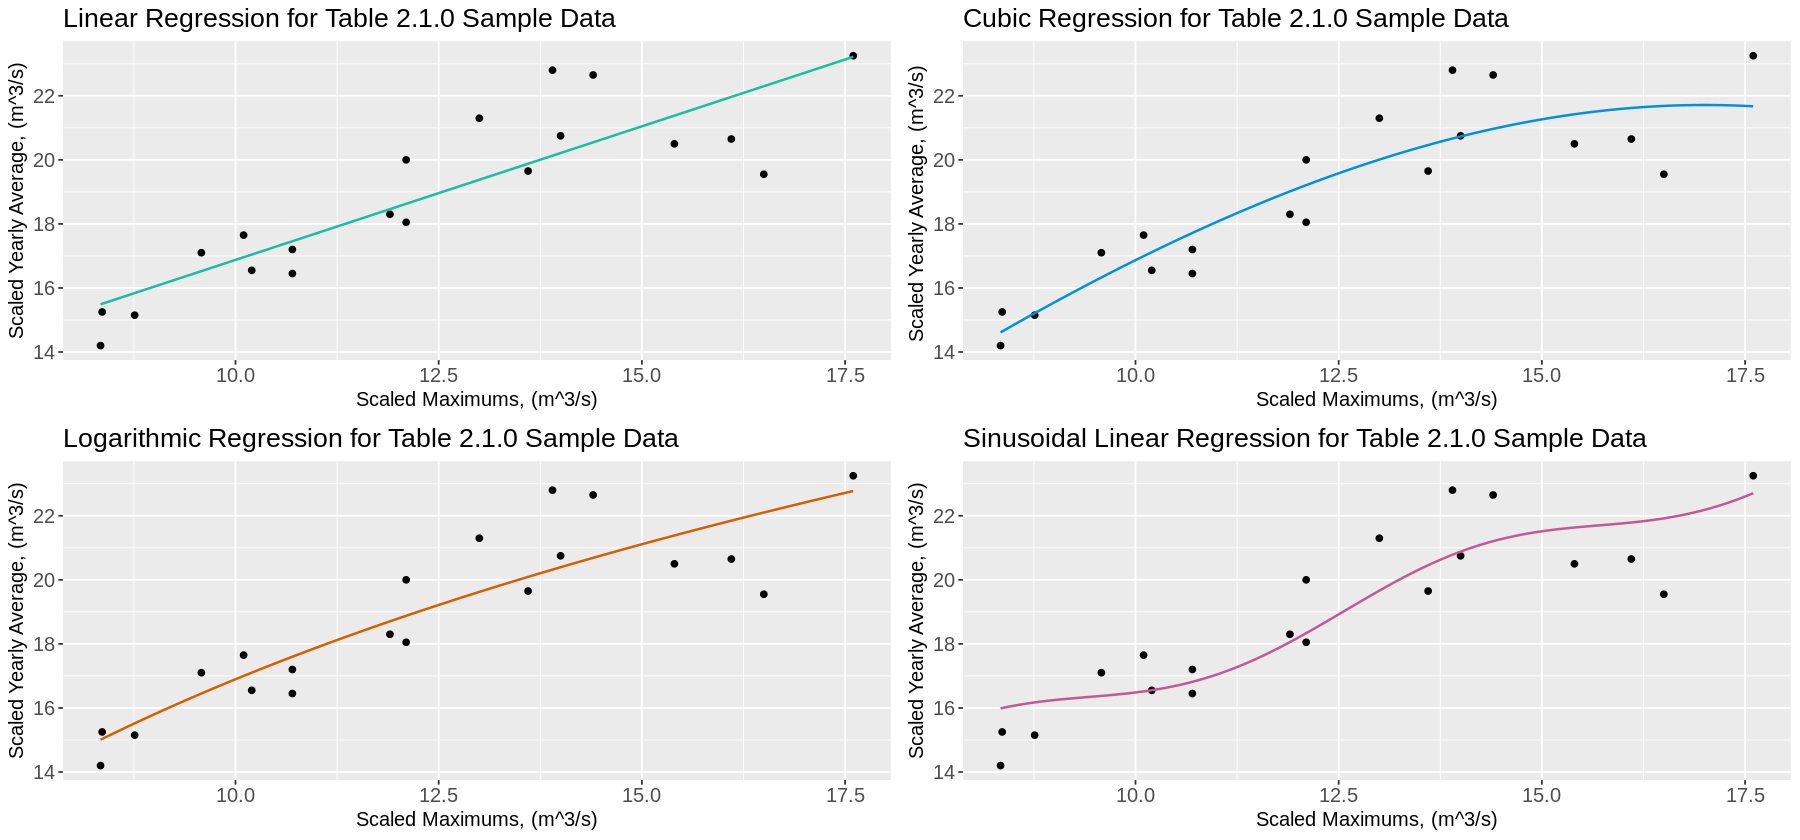

In [64]:
# arrange all four approximating functions side-by-side
grid.arrange(plt_lin, plt_reg, plt_log, plt_sin,  ncol = 2, nrow = 2) 

<h4>Compare All Approximations with Original Data</h4>
From this visualization we can consider the point estimates we will use in the next section.

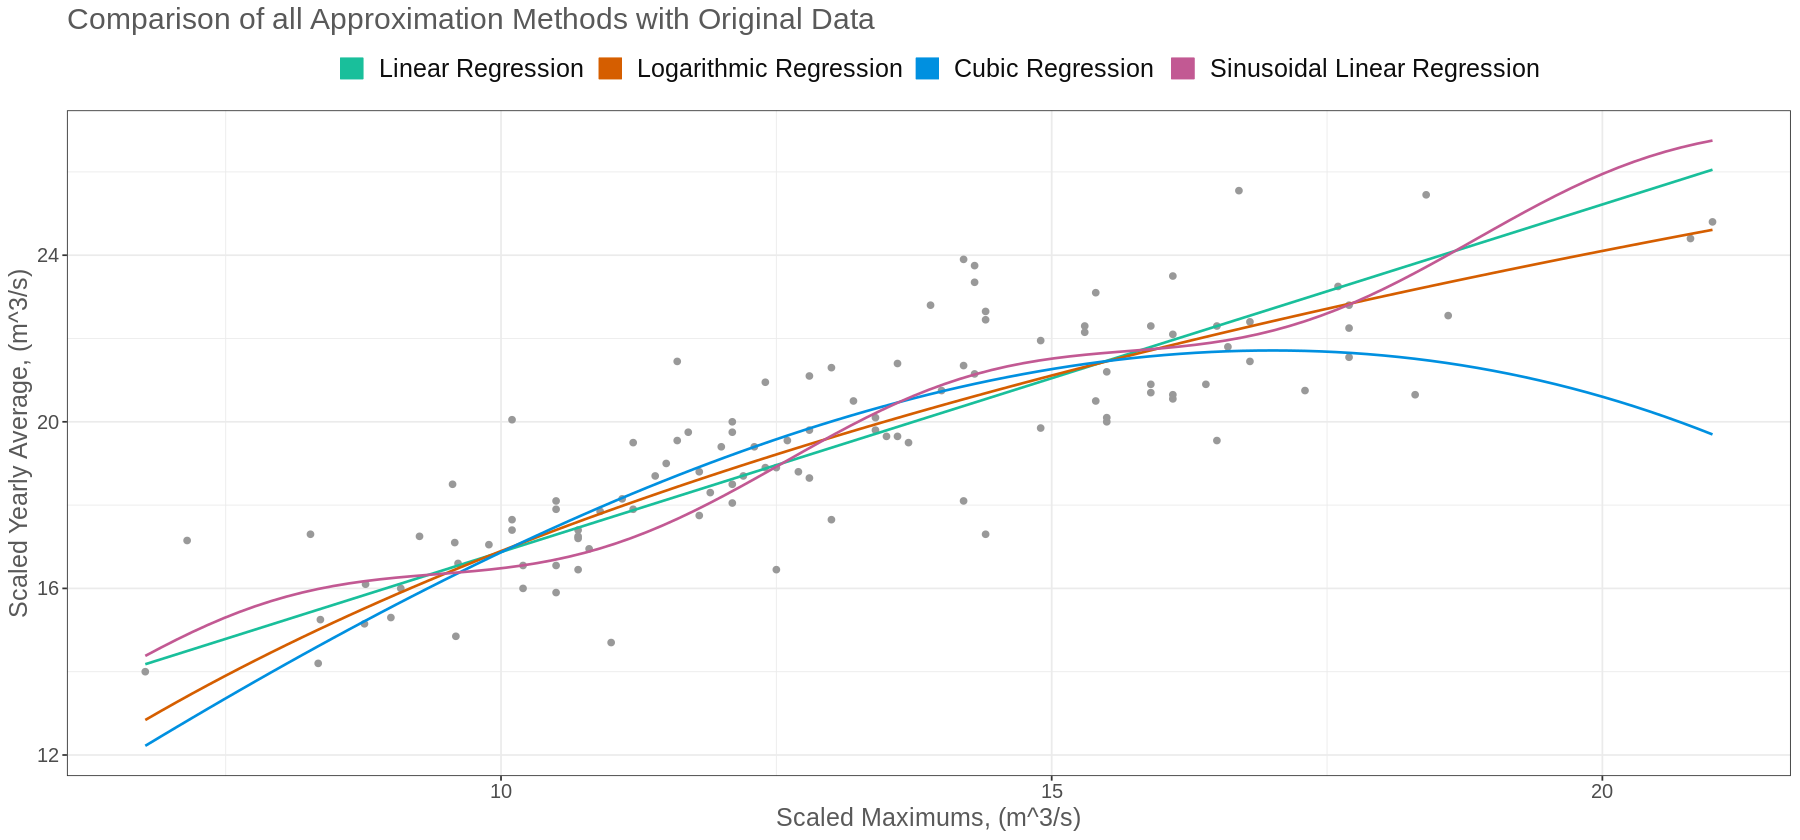

In [65]:
# Reshape dataframe columns according to magnitude simplifications
modified_fn_input =  0.10*as.numeric(computeDF$max)
modified_df_actual = 0.5*(as.numeric(computeDF$mean_filtered))

# create different range dataframes so that functions can be factors, helps for legends & colours
plot.range1 <- data.frame(x = modified_fn_input, Functions = factor(1))
plot.range2 <- data.frame(x = modified_fn_input, Functions = factor(2))
plot.range3 <- data.frame(x = modified_fn_input, Functions = factor(3))
plot.range4 <- data.frame(x = modified_fn_input, Functions = factor(4))

# create plot against original data with all functions
ggplot(NULL, aes(x =x , colour=Functions)) +
    # plot data points as light grey
    geom_point(inherit.aes = FALSE, aes(x = modified_fn_input, y = modified_df_actual), color = "grey60") +
    # plot each regression line
    stat_function(data = plot.range1, fun = lineartoCurve, lwd = 0.75) +
    stat_function(data = plot.range2, fun = logtoCurve, lwd = 0.75) +
    stat_function(data = plot.range3, fun = cubetoCurve, lwd = 0.75) +
    stat_function(data = plot.range4, fun = sintoCurve, lwd = 0.75) +
    # preserve colour theme of previous plot
    scale_colour_manual(values = c("#19bf9b", "#D55E00", "#0090e0", "#c25993"), 
                        labels = c("Linear Regression ", "Logarithmic Regression " , 
                                   "Cubic Regression ", "Sinusoidal Linear Regression ")) +
    # add axus labels
    ggtitle("Comparison of all Approximation Methods with Original Data") + 
    labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") + theme_bw() + 
    # customize theme
    theme(text = element_text(size = 15, color = "grey35"), # make text lighter 
          legend.text = element_text(size = 15, color = "grey5"), # legend darker
          legend.position = "top",  # relocate legend
          legend.title = element_blank()) +  # remove the title
    # add manual fill boxes for legend (easier reading)
    guides(colour = guide_legend(override.aes = list(size = 6)))

<h4>Compute the RSS and Mean Residuals:</h4>
<p> Using $RSS = \sum_{i = 1}^n (y_i - \hat{y}_i)^2 $ where $\hat{y}_i = f(x_i)$ is the predicted $y_i$ at $x_i$, and $(x_i, y_i)$ is the $i$-th point from the original data. For each of the functions, we will compute the RSS as well as the Average Residual, giving us two point estimates apiece.

In [66]:
# Compute the Residuals of each model
# Where the residual is "Predicted Y - Actual Y"
resid_sin = (sintoCurve(modified_fn_input) - modified_df_actual)
resid_cub = (cubetoCurve(modified_fn_input) - modified_df_actual)
resid_log = (logtoCurve(modified_fn_input) - modified_df_actual)
resid_lin = (lineartoCurve(modified_fn_input) - modified_df_actual)

# Summarize our findings in a Data Frame, and make it look like a table
pt2_Results = data.frame(
                 # by definition RSS is the sum of the squared residuals
                RSS = c(sum(resid_sin^2), 
                        sum(resid_cub^2), 
                        sum(resid_log^2), 
                        sum(resid_lin^2)),
                  # also find the avg. residual for further comparisons
                Mean_Residual = c(
                        mean(resid_sin),  
                        mean(resid_cub), 
                        mean(resid_log), 
                        mean(resid_lin)))
# Set Row Names to Improve Clarity
rownames(pt2_Results) = c("Sinusoidal Linear","Cubic","Logarithmic","Linear")
cat("Table 2.1.1")
pt2_Results

Table 2.1.1

,RSS,Mean_Residual
,<dbl>,<dbl>
Sinusoidal Linear,232.1306,-0.1675986
Cubic,277.4218,-0.2503623
Logarithmic,219.3422,-0.1396495
Linear,228.7417,-0.1169057


<h3> <u> Part 3: Repeat this Process to Create a Sampling Distribution </u> </h3>
The information contained in Table 2.1.1 are merely point estimates from a single sample. <br>
The following two data frames are the result of repeating the process above a total of 100 times (sample size $n=20$). We included the randomization seeds in the "Seeds" column. (We verify the 2002 Seed).<p>
We generated the data separately to optimize runtime.<br>
    "<i>regression_RSS_scores</i>" contains the RSS for each function in each trial. It has 5 Columns - one for each approximating function and one for the trial seed. Similarly,  "<i>regression_avg_scores</i>" contains the Mean Residuals and has identical nomenclature.

In [67]:
# import the simulation/training data
regression_RSS_scores = read.csv("https://raw.githubusercontent.com/cadenhewlett/stat-201-group-33-project/main/regression_results.csv") 
regression_avg_scores = read.csv("https://raw.githubusercontent.com/cadenhewlett/stat-201-group-33-project/main/avg_resid_results_new.csv")
# here you can confirm that the starting seed for the iterative sampling yields the exact same results as the process above
cat("Table 3.1.0")
regression_RSS_scores[regression_RSS_scores$SEED == 2002, ]
regression_avg_scores[regression_avg_scores$Seed == 2002, ]

Table 3.1.0

,Sinusoidal.Linear,Cubic,Logarithmic,Linear,SEED
,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,232.1306,277.4218,219.3422,228.7417,2002


,Sinusoidal.Linear,Cubic,Logarithmic,Linear,Seed
,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-0.1675986,-0.2503623,-0.1396495,-0.1169057,2002


<h4> Part 3a: ANOVA Test for Average Residuals </h4>
Before we continue, we should confirm that across the samples the approximating functions remained precise. We expect that across the functions in our trials, the <i>mean</i> residual scores $\overline{r}$ should not differ too much, since the functions have residuals centered about $0$.
<br>
We should observe the same population average residual across the 4 functions, defined as $\overline{R}_1, \dots, \overline{R}_4.$ <br>

Therefore, we will test the hypothesis at $\alpha = 0.05$:
$$H_0: \overline{R}_1 = \overline{R}_2 = \overline{R}_3 = \overline{R}_4$$
$$H_A: \text{At least one of the means are not equal  to the others.} $$

In [89]:
# here we pivot the dataframe and add the "Model_Type" column to each sub-dataframe
# this will give us a numeric variable and a categorical variable for our ANOVA test
sindf = data.frame(Average_Residual = regression_avg_scores$Sinusoidal.Linear, Model_Type = "Sinusoidal Linear")
cubdf = data.frame(Average_Residual = regression_avg_scores$Cubic, Model_Type = "Cubic")
logdf = data.frame(Average_Residual = regression_avg_scores$Logarithmic, Model_Type = "Logarithmic")
lindf = data.frame(Average_Residual = regression_avg_scores$Linear, Model_Type = "Linear")

# conduct ANOVA test
cat("Table 3.1.1")
broom::tidy(aov(Average_Residual ~ Model_Type, data = rbind(sindf, cubdf, logdf, lindf)))

Table 3.1.1

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model_Type,3,0.2009326,0.06697752,0.6865817,0.5606558
Residuals,400,39.0208564,0.09755214,NA,NA


With an observed p-value of $p = 0.56$, we fail to reject $H_0$ at $\alpha = 0.05$. There's insufficient evidence to suggest that the average residuals are different across the four Models. We can safely determine which model had the lowest Residual Sum of Squares across the trials.

<h4> Part 3b: Compute Pairwise Confidence Intervals </h4>
Let's compare Difference of Mean $RSS$ Scores to determine which approximating function performed the best. <br>

Each confidence interval will be constructed at $\alpha = 0.05$, meaning that in many repeated trials similar to those we conducted, 95 times out of 100 we can say the true population parameter of $RSS$ differences will fall between $CI_\text{lower}$ and $CI_\text{upper}$. The distributions of the differences in $RSS$ scores appear to be normal.
<br>

In [91]:
# create an empty data frame with column names that we will add data to
scoreDF = data.frame( matrix(ncol = 5, nrow = 0,  # declare dimensions
                      dimnames = list(NULL, c("model", "compared_against", "lower_int", "upper_int", "performance")))) # declare column names
# store function names for iteration
names =  c('Sinusoidal.Linear','Cubic','Logarithmic','Linear')

# this loop will construct 12 confidence intervals for the different methods
for (i in 1:4){ # for each approximating method
    # get the i-th estimation name from the list of column names
    rss1 = switch(i, 'Sinusoidal.Linear','Cubic','Logarithmic','Linear') 
    # then, for each element not in this selection
    for (rss2 in names[!names == rss1]){
        # construct the 95% confidence interval for the difference of these two methods
        interval = broom::tidy(t.test(x = t(regression_RSS_scores[rss1]), 
                                      y = t(regression_RSS_scores[rss2]),
                                      alternative = "two.sided",
                                      paired = TRUE, conf.level = 0.95))
        # append the intervals, the "target" model and the model compared against it to the DF, 
        scoreDF[nrow(scoreDF) + 1, ] = c(rss1, rss2, interval$conf.low, interval$conf.high, 
                                         # "contains zero" not included here.
                                         ifelse(interval$conf.low < 0 && interval$conf.high < 0, "better", "worse"))
        } #repeat
    }

# add a column that summarizes findings in an easy-to-understand manner
scoreDF["conclusion"] = paste((scoreDF$model), "performs", (scoreDF$performance), "than", (scoreDF$compared_against))

# and display the relevant columns from the results table
cat("Table 3.2.0: CIs of RSS differences of \"model\" - \"compared_against\"") # table name
scoreDF[colnames(scoreDF) %in% c('model', 'compared_against', 'lower_int', 'upper_int', 'conclusion')] #relevant results

Table 3.2.0: CIs of RSS differences of "model" - "compared_against"

,model,compared_against,lower_int,upper_int,conclusion
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Sinusoidal.Linear,Cubic,-40.2558124427681,-9.32869426416258,Sinusoidal.Linear performs better than Cubic
2,Sinusoidal.Linear,Logarithmic,9.63978347870476,19.6770650321863,Sinusoidal.Linear performs worse than Logarithmic
3,Sinusoidal.Linear,Linear,4.11614442111592,13.2441988739336,Sinusoidal.Linear performs worse than Linear
4,Cubic,Sinusoidal.Linear,9.32869426416258,40.2558124427681,Cubic performs worse than Sinusoidal.Linear
5,Cubic,Logarithmic,24.418086395978,54.4832688218438,Cubic performs worse than Logarithmic
6,Cubic,Linear,18.4935637190492,48.451286282931,Cubic performs worse than Linear
7,Logarithmic,Sinusoidal.Linear,-19.6770650321863,-9.63978347870476,Logarithmic performs better than Sinusoidal.Linear
8,Logarithmic,Cubic,-54.4832688218438,-24.418086395978,Logarithmic performs better than Cubic
9,Logarithmic,Linear,-7.89066331200266,-4.06584190383892,Logarithmic performs better than Linear


<h3> Results, Interpretation and Relevance (Part 3)</h3>

<u><i>Table 3.2.0</i></u>: If the interval bounds for a method ("model") against another ("compared_against") contains 0, then we lack statistically significant evidence evidence at $\alpha$ to conclude the overall RSS are different for the functions. If the interval is *entirely positive*, this implies the *first* model performs <b>worse</b> than the "compared_against", since $RSS_1 - RSS_2 > 0 \implies RSS_1 > RSS_2$. By similar thinking, if the interval is *entirely negative*, this insinuates the *first*, model performs <b>better</b>  than the "compared_against". It follows that a function that has solely negative CIs is the best performing compared to the three others.<br>

<u><i>Findings</i></u>: From Table 3.2.0, we know the Logarithmic function performed best - the intervals are negative, indicating that in each instance (at $\alpha$) the Logarithmic Regression has a lower RSS than the three other functions compared against it. This is a good indication that for samples this size, the relationship of Maximum River Flow vs. Yearly Average follow a Logarithmic Model. <br>
<u><i>Part 3 Conclusion</i></u>: We conclude that, for data similar to  Station 05BB001, a logarithmic regression fits the data best when compared against cubic, linear and sinusoidal linear (note, this doesn't mean there isn't a better function). One impact of these results is that an investigation into the Maximum River Flow vs. Yearly Average datasets similar to Station 05BB001 should *not* assume the data are linear; moreover, it's logarithmic. This result was surprising, since the original investigation of the data seemed to favour linearity.

<h3> Future Work (Part 3) </h3>
One avenue of future work would be to conduct a Bayesian analysis for a set of similar flow rate data using a Logarithmic prior. Another possible avenue would be to test these four estimation methods against different river flow rate datasets, to investigate if the Logarithmic model is unique to the Bow River.

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.1//EN" "http://www.w3.org/TR/xhtml11/DTD/xhtml11.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>
    <h4><b>Sources and Related Work</b></h4>
</head>
<body>
<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Merkuryeva, G. V., &amp; Kornevs, M. (2013). Water Flow Forecasting and River Simulation for Flood Risk Analysis. <i>Information Technology and Management Science</i>, <i>16</i>(1). <a href="https://doi.org/10.2478/itms-2013-0006">https://doi.org/10.2478/itms-2013-0006</a></div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.2478%2Fitms-2013-0006&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Water%20Flow%20Forecasting%20and%20River%20Simulation%20for%20Flood%20Risk%20Analysis&amp;rft.jtitle=Information%20Technology%20and%20Management%20Science&amp;rft.volume=16&amp;rft.issue=1&amp;rft.aufirst=Galina%20V.&amp;rft.aulast=Merkuryeva&amp;rft.au=Galina%20V.%20Merkuryeva&amp;rft.au=Maksims%20Kornevs&amp;rft.date=2013-01-01&amp;rft.issn=2255-9094%2C%202255-9086"></span>
</div></body>
    </head>
<body>
<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Kreibich, H., Piroth, K., Seifert, I., Maiwald, H., Kunert, U., Schwarz, J., Merz, B., &amp; Thieken, A. H. (2009). Is flow velocity a significant parameter in flood damage modelling? <i>Natural Hazards and Earth System Sciences</i>, <i>9</i>(5), 1679–1692. <a href="https://doi.org/10.5194/nhess-9-1679-2009">https://doi.org/10.5194/nhess-9-1679-2009</a></div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.5194%2Fnhess-9-1679-2009&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Is%20flow%20velocity%20a%20significant%20parameter%20in%20flood%20damage%20modelling%3F&amp;rft.jtitle=Natural%20Hazards%20and%20Earth%20System%20Sciences&amp;rft.stitle=Nat.%20Hazards%20Earth%20Syst.%20Sci.&amp;rft.volume=9&amp;rft.issue=5&amp;rft.aufirst=H.&amp;rft.aulast=Kreibich&amp;rft.au=H.%20Kreibich&amp;rft.au=K.%20Piroth&amp;rft.au=I.%20Seifert&amp;rft.au=H.%20Maiwald&amp;rft.au=U.%20Kunert&amp;rft.au=J.%20Schwarz&amp;rft.au=B.%20Merz&amp;rft.au=A.%20H.%20Thieken&amp;rft.date=2009-10-14&amp;rft.pages=1679-1692&amp;rft.spage=1679&amp;rft.epage=1692&amp;rft.issn=1684-9981&amp;rft.language=en"></span>
</div></body>
</html>


<i>Original data sourced from</i> <a href="https://wateroffice.ec.gc.ca/">https://wateroffice.ec.gc.ca/</a>, <i>Government of Canda, wherein the tables are considered public information and may be distributed or copied. Please visit</i>  <a href=" https://www.canada.ca/en/transparency/terms.html"> https://www.canada.ca/en/transparency/terms.html</a> <i>for more information on reproducibility.</i>